# Sound Switch

# Imports

In [44]:
%reset -f
%matplotlib inline
%config InlineBackend.figure_format = "retina" # High-res graphs (rendered irrelevant by svg option below)
%config InlineBackend.print_figure_kwargs = {"bbox_inches": "tight"} # No extra white space
%config InlineBackend.figure_format = "svg" # 'png' is default
 
import warnings
warnings.filterwarnings("ignore") # Because we are adults
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from dfply import *

# iPyPublish imports
# from ipypublish.scripts.ipynb_latex_setup import *
# from IPython.display import SVG, display, Markdown

# Experiment 1

## Methods

### Stimuli
- Two types of sound stimuli: tones and guitar chords
    - Beeps alternate between pure C4 tone (261.626 Hz) and pure G tone (391.995 Hz)
    - Guitar chords alternate between a C chord and a G chord strummed on guitar, taken from [here](https://www.apronus.com/music/onlineguitar.htm), which were subsequently recorded and amplified (25.98 db and 25.065 db respectively) using Audacity version 2.3.0 (using Effect --> Amplify) via Windows 10's Stereo Mix drivers.
- 20 sounds per stimulus
- Crossfade of 50 ms between sounds
- Each stimulus was 10,000 milliseconds long, with an additional 150 ms of silence at the start of the recording.
- 9 switch rates between 0.1 and 0.9
- 10 stimuli for each switch rate, for a total of 180 stimuli, all presented as a single block. 30 frame ITI.
- 20 repeated stimuli chosen via the same random choice for each subject (presentation order was via a unique random choice for each subject, however).
- One practice beep stimulus at 0.5 switch rate presented at the start of the experiment.


## Results

### Read in data

In [45]:
import glob, os

separator = r"\t"
data_dir = "../data"
prefix = "Sound Switch"
extension = ".txt"
search = f"{data_dir}/{prefix}*{extension}"

# Get each subject's data and concatenate into 
# one larger DataFrame
all_data = pd.DataFrame()
for file_name in glob.glob(search):
    subject_data = pd.read_csv(file_name, sep=separator)
    if all_data.shape == (0, 0):
        all_data = subject_data
    else: 
        all_data = all_data.append(subject_data)

all_data.reset_index(inplace=True, drop=True)
all_data.head()

,Subject ID,Condition,Block #,Trial #,Switch Rate,Exemplar,File Name,Rating,RT,Rating History,Trial Duration,Block Duration,Session Duration,Experiment Duration,Start Date,Experiment,Testing Location,Experimenter Initials,Subject Initials
0,1,patterned,1,1,0.3,10,../stimuli/combined/switch-0.3_chunk-500_C_G_a...,41,7.309,"[(None, 0.0), (41, 6.48), (41, 7.309)]",18.222353,18.223059,3670.838750,19.814849,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH
1,1,patterned,1,2,0.1,17,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,100,2.725,"[(None, 0.0), (100, 1.817), (100, 2.725)]",13.631996,31.859845,3684.475536,33.451635,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH
2,1,patterned,1,3,0.1,18,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,71,3.493,"[(None, 0.0), (71, 2.784), (71, 3.493)]",14.413484,46.279105,3698.894796,47.870896,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH
3,1,patterned,1,4,0.7,10,../stimuli/combined/switch-0.7_chunk-500_C_G_a...,68,2.446,"[(None, 0.0), (68, 1.726), (68, 2.446)]",13.391476,59.676363,3712.292055,61.268155,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH
4,1,patterned,1,5,0.9,9,../stimuli/combined/switch-0.9_chunk-500_C_G_a...,100,2.178,"[(None, 0.0), (100, 1.333), (100, 2.178)]",13.100105,72.781313,3725.397003,74.373104,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH


### Determine stimulus type

In [46]:
def get_stimulus_type(row):
    """
    All stimuli under 10 are guitar; the rest are tones.
    """
    return "guitar" if row["Exemplar"] < 10 else "tone"

all_data["Stimulus Type"] = all_data.apply(get_stimulus_type, axis=1)
all_data.head()

,Subject ID,Condition,Block #,Trial #,Switch Rate,Exemplar,File Name,Rating,RT,Rating History,Trial Duration,Block Duration,Session Duration,Experiment Duration,Start Date,Experiment,Testing Location,Experimenter Initials,Subject Initials,Stimulus Type
0,1,patterned,1,1,0.3,10,../stimuli/combined/switch-0.3_chunk-500_C_G_a...,41,7.309,"[(None, 0.0), (41, 6.48), (41, 7.309)]",18.222353,18.223059,3670.838750,19.814849,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone
1,1,patterned,1,2,0.1,17,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,100,2.725,"[(None, 0.0), (100, 1.817), (100, 2.725)]",13.631996,31.859845,3684.475536,33.451635,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone
2,1,patterned,1,3,0.1,18,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,71,3.493,"[(None, 0.0), (71, 2.784), (71, 3.493)]",14.413484,46.279105,3698.894796,47.870896,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone
3,1,patterned,1,4,0.7,10,../stimuli/combined/switch-0.7_chunk-500_C_G_a...,68,2.446,"[(None, 0.0), (68, 1.726), (68, 2.446)]",13.391476,59.676363,3712.292055,61.268155,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone
4,1,patterned,1,5,0.9,9,../stimuli/combined/switch-0.9_chunk-500_C_G_a...,100,2.178,"[(None, 0.0), (100, 1.333), (100, 2.178)]",13.100105,72.781313,3725.397003,74.373104,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,guitar


### Determine if trial is a repeated stimulus

In [47]:
num_trials = 200
num_repeated_trials = 20 # at end of task
start_repeated_trial_index = num_trials - num_repeated_trials + 1

all_data["Repeat Trial"] = all_data["Trial #"] >= start_repeated_trial_index
all_data.head()

,Subject ID,Condition,Block #,Trial #,Switch Rate,Exemplar,File Name,Rating,RT,Rating History,...,Block Duration,Session Duration,Experiment Duration,Start Date,Experiment,Testing Location,Experimenter Initials,Subject Initials,Stimulus Type,Repeat Trial
0,1,patterned,1,1,0.3,10,../stimuli/combined/switch-0.3_chunk-500_C_G_a...,41,7.309,"[(None, 0.0), (41, 6.48), (41, 7.309)]",...,18.223059,3670.838750,19.814849,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
1,1,patterned,1,2,0.1,17,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,100,2.725,"[(None, 0.0), (100, 1.817), (100, 2.725)]",...,31.859845,3684.475536,33.451635,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
2,1,patterned,1,3,0.1,18,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,71,3.493,"[(None, 0.0), (71, 2.784), (71, 3.493)]",...,46.279105,3698.894796,47.870896,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
3,1,patterned,1,4,0.7,10,../stimuli/combined/switch-0.7_chunk-500_C_G_a...,68,2.446,"[(None, 0.0), (68, 1.726), (68, 2.446)]",...,59.676363,3712.292055,61.268155,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
4,1,patterned,1,5,0.9,9,../stimuli/combined/switch-0.9_chunk-500_C_G_a...,100,2.178,"[(None, 0.0), (100, 1.333), (100, 2.178)]",...,72.781313,3725.397003,74.373104,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,guitar,False


### Remove subjects with "None" ratings

In [48]:
subjects_with_missing_data = all_data[all_data["Rating"] == "None"]["Subject ID"]
print(f"Bad subjects: \n {subjects_with_missing_data}")
all_data = all_data[~all_data["Subject ID"].isin(subjects_with_missing_data)]

Bad subjects: 
 6347    32
Name: Subject ID, dtype: int64


### Re-convert ratings to numeric

In [49]:
all_data["Rating"] = pd.to_numeric(all_data["Rating"])

### Get subject reliability

In [61]:
subject_reliability_df = pd.DataFrame(
    index=[],
    columns=[
        "subject_id",
        "condition",        
        "correlation",
        "p-value",
        "fisher_z",
    ],
)
subject_ids = all_data["Subject ID"].unique()
for subject_id in subject_ids:
    subject_data = all_data >> mask(X["Subject ID"] == subject_id)
    subject_data.sort_values(by=["File Name"], inplace=True)
    repeated_stimuli = (
        subject_data 
        >> mask(X["Repeat Trial"] == True)
        >> select(["File Name"])
    )
    
    first_ratings_data = subject_data[
        (subject_data["File Name"].isin(repeated_stimuli["File Name"]))
        & (subject_data["Repeat Trial"] == False)
    ]["Rating"].tolist()
    
    second_ratings_data = subject_data[
        (subject_data["File Name"].isin(repeated_stimuli["File Name"]))
        & (subject_data["Repeat Trial"] == True)
    ]["Rating"].tolist()
    
    subject_reliability_corr = scipy.stats.pearsonr(
        first_ratings_data, second_ratings_data
    )
    
    # Needs to be in arrays for pandas
    # XXX break down by stimulus type?
    this_corr_row = {
        "subject_id": [subject_id],
        "condition": [subject_data["Condition"].iloc[0]],        
        "correlation": [subject_reliability_corr[0]],
        "p-value": [subject_reliability_corr[1]],
        "fisher_z": [np.arctanh(subject_reliability_corr[0])],
    }
    this_corr_row = pd.DataFrame.from_dict(this_corr_row)
    subject_reliability_df = subject_reliability_df.append(this_corr_row)
    
subject_reliability_df

,subject_id,condition,correlation,p-value,fisher_z
0,1,patterned,0.104783,6.601953e-01,0.105169
0,2,beautiful,0.952372,1.007080e-10,1.856693
0,3,patterned,0.633475,2.712090e-03,0.747199
0,4,beautiful,0.206562,3.822442e-01,0.209577
0,5,patterned,0.795481,2.754297e-05,1.086183
0,6,beautiful,-0.176351,4.570326e-01,-0.178214
0,7,patterned,0.300609,1.978025e-01,0.310189
0,8,beautiful,0.937796,1.055227e-09,1.719447
0,9,patterned,-0.157391,5.075215e-01,-0.158710
0,10,beautiful,0.165464,4.857024e-01,0.166999


### Remove unreliable subjects

In [62]:
# Keep subjects with positive correlation
subject_reliability_df = subject_reliability_df[subject_reliability_df["correlation"] >= 0]
# Keep subjects that have defined data
subject_reliability_df = subject_reliability_df.replace(
    [np.inf, -np.inf], np.nan
).dropna()
reliable_subjects = subject_reliability_df["subject_id"].unique()
no_repeat_data = all_data[(all_data["Subject ID"].isin(reliable_subjects)) & (all_data["Repeat Trial"]==False)]
print(f"Remaining participants: {subject_reliability_df.shape[0]}")
print(f"Data without repeat trials:")
no_repeat_data.head()

Remaining participants: 30
Data without repeat trials:


,Subject ID,Condition,Block #,Trial #,Switch Rate,Exemplar,File Name,Rating,RT,Rating History,...,Block Duration,Session Duration,Experiment Duration,Start Date,Experiment,Testing Location,Experimenter Initials,Subject Initials,Stimulus Type,Repeat Trial
0,1,patterned,1,1,0.3,10,../stimuli/combined/switch-0.3_chunk-500_C_G_a...,41,7.309,"[(None, 0.0), (41, 6.48), (41, 7.309)]",...,18.223059,3670.838750,19.814849,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
1,1,patterned,1,2,0.1,17,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,100,2.725,"[(None, 0.0), (100, 1.817), (100, 2.725)]",...,31.859845,3684.475536,33.451635,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
2,1,patterned,1,3,0.1,18,../stimuli/combined/switch-0.1_chunk-500_C_G_a...,71,3.493,"[(None, 0.0), (71, 2.784), (71, 3.493)]",...,46.279105,3698.894796,47.870896,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
3,1,patterned,1,4,0.7,10,../stimuli/combined/switch-0.7_chunk-500_C_G_a...,68,2.446,"[(None, 0.0), (68, 1.726), (68, 2.446)]",...,59.676363,3712.292055,61.268155,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,tone,False
4,1,patterned,1,5,0.9,9,../stimuli/combined/switch-0.9_chunk-500_C_G_a...,100,2.178,"[(None, 0.0), (100, 1.333), (100, 2.178)]",...,72.781313,3725.397003,74.373104,2019_Feb_14_1305,Sound Switch 12-20-2018,318-laptop,bpl,WPH,guitar,False


### Group results
Keep only reliable subjects and remove repeated trials.

In [63]:
main_results = (
    no_repeat_data
    >> group_by("Condition", "Switch Rate", "Stimulus Type")
    >> summarize(mean_ratings=X.Rating.mean(), sd_ratings=X.Rating.std())
)
main_results.head()

,Stimulus Type,Switch Rate,Condition,mean_ratings,sd_ratings
0,guitar,0.1,beautiful,37.314286,23.236379
1,tone,0.1,beautiful,19.235714,18.152278
2,guitar,0.2,beautiful,42.107143,21.433080
3,tone,0.2,beautiful,24.928571,18.964428
4,guitar,0.3,beautiful,45.135714,20.673624


### Plot results

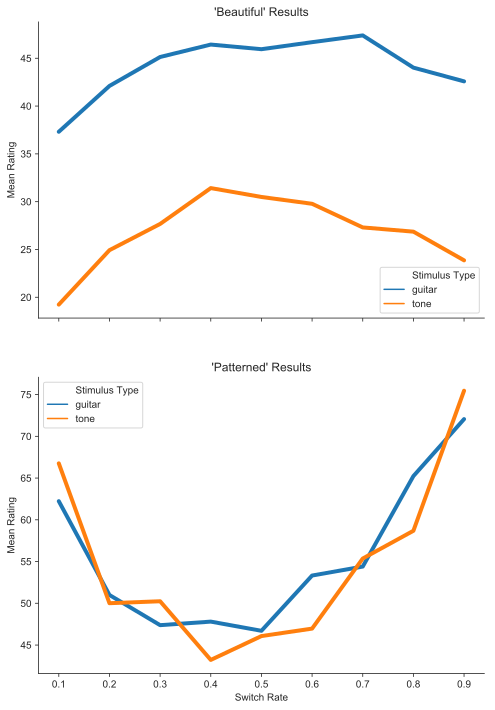

In [65]:
f, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
sns.despine()
for i, condition in enumerate(main_results["Condition"].unique()):
    these_results = main_results >> mask(X["Condition"] == condition)
    # Convert complexity labels to more informative string labels.
    # Note that seaborn has problems with numbers as categories, 
    # and simple string conversion via `str` doesn't work.    
    sns.lineplot(
        x="Switch Rate",
        y="mean_ratings",
        hue="Stimulus Type",
        data=these_results,
        ax=ax[i],
        linewidth=4
    )
    ax[i].set_title(f"'{condition.title()}' Results")
    ax[i].set(xlabel='Switch Rate', ylabel='Mean Rating')    
plt.show()

# Sanity checks

## Same number of trials for all subjects?
All subjects should have exactly 200 trials.

In [54]:
subject_ids = all_data["Subject ID"].unique()
for subject_id in subject_ids:
    subject_data = all_data >> mask(X["Subject ID"] == subject_id)
    print(subject_data.shape)

(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)
(200, 21)


## All stimuli same length?
Should all be 10,100 ms long.

In [55]:
test_sanity = False
if test_sanity:
    from pydub import AudioSegment

    stimulus_dir = "../stimuli/combined"
    prefix = "switch-"
    extension = ".mp3"
    search = f"{stimulus_dir}/{prefix}*{extension}"

    song_durations = []
    for song_name in glob.glob(search):
        song = AudioSegment.from_mp3(song_name)
        song_durations.append(len(song))

    print(set(song_durations))

# Exploration

## RT

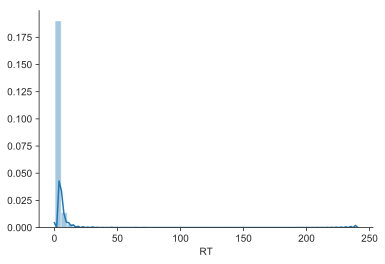

In [56]:
sns.set_style("ticks")
sns.distplot(all_data["RT"])
sns.despine()

# Scrap

In [57]:
# Remove subjects with "None" rating data
all_data = all_data.replace(to_replace="None", value=np.nan).dropna()

In [58]:
# subject_reliability_df = pd.DataFrame(
#     index=[],
#     columns=[
#         "subject_id",
#         "condition",        
#         "correlation",
#         "p-value",
#         "fisher_z",
#     ],
# )
# subject_ids = all_data["Subject ID"].unique()
# for subject_id in subject_ids:
#     subject_data = all_data >> mask(X["Subject ID"] == subject_id)
#     subject_data.sort_values(by=["File Name"], inplace=True)
#     repeated_stimuli = (
#         subject_data 
#         >> mask(X["Repeat Trial"] == True)
#         >> select(["File Name"])
#     )
    
#     first_ratings_data = subject_data[
#         (subject_data["File Name"].isin(repeated_stimuli["File Name"]))
#         & (subject_data["Repeat Trial"] == False)
#     ]["Rating"].tolist()
    
#     second_ratings_data = subject_data[
#         (subject_data["File Name"].isin(repeated_stimuli["File Name"]))
#         & (subject_data["Repeat Trial"] == True)
#     ]["Rating"].tolist()
    
#     # Correct for subjects where one or more repeat trials had to be discarded
#     if len(first_ratings_data) != len(second_ratings_data):
#         first_ratings_stimuli = subject_data[
#             (subject_data["File Name"].isin(repeated_stimuli["File Name"]))
#             & (subject_data["Repeat Trial"] == False)
#         ]["File Name"].tolist()
        
#         second_ratings_stimuli = subject_data[
#             (subject_data["File Name"].isin(repeated_stimuli["File Name"]))
#             & (subject_data["Repeat Trial"] == True)
#         ]["File Name"].tolist()
                
#         if len(first_ratings_stimuli) < len(second_ratings_stimuli):
#             smaller_set = set(first_ratings_stimuli)
#             larger_set = set(second_ratings_stimuli)
#         else:
#             smaller_set = set(second_ratings_stimuli)
#             larger_set = set(first_ratings_stimuli)
                    
#         missing_stimuli = larger_set.difference(smaller_set)
#         pass
    
#     subject_reliability_corr = scipy.stats.pearsonr(
#         first_ratings_data, second_ratings_data
#     )
    
#     # Needs to be in arrays for pandas
#     # XXX break down by stimulus type?
#     this_corr_row = {
#         "subject_id": [subject_id],
#         "condition": [subject_data["Condition"].iloc[0]],        
#         "correlation": [subject_reliability_corr[0]],
#         "p-value": [subject_reliability_corr[1]],
#         "fisher_z": [np.arctanh(subject_reliability_corr[0])],
#     }
#     this_corr_row = pd.DataFrame.from_dict(this_corr_row)
#     subject_reliability_df = subject_reliability_df.append(this_corr_row)
    
# subject_reliability_df